## This code performs data mining with one of Google Cloud Platform products : Google Street View API (GSV API)

Chosen regions, depicted with rectangular boundary defined with (latitude_south, latitude_north, longitude_west, longitude_east) were used to generate hundreds/thousands of random coordinates within the boundary.

Then, GSV API will try to determine whether the random coordinates were valid coordinates where panoramic views of street view were available.

If the panoramas were available, our CNN binary classifier will predict whether the panoramas were buildings or other objects.

If the CNN binary classifier found that the panoramas were buildings, then the panoramas will be saved to local disk.

Else, the panoramas will be deleted and GSV API will try to discover other panoramas with different random coordinates

In [ ]:
import pandas as pd
import numpy as np
import time
import random
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
from keras import backend as K
from tensorflow.keras import models
from tensorflow.keras import mixed_precision
from tensorflow.keras.preprocessing import image

In [ ]:
from pathlib import Path
from PIL import Image
import os, shutil
from os import listdir
## Image Resizing
from PIL import Image

In [ ]:
def generate_random_coord(coords):
    lat_rand = np.random.uniform(coords[0], coords[1], size=None)
    lon_rand = np.random.uniform(coords[2], coords[3], size=None)
    file_name = str(np.round(lat_rand,7)) + ' - ' + str(np.round(lon_rand,7))
    #cache = np.array((lat_rand,lon_rand))
    return str(lat_rand) + ',' + str(lon_rand), file_name

In [ ]:
def preprocess_image(path, target_size = (256,256)):
    img = image.load_img(path, target_size = target_size)
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    img_preprocessed = img_batch/255.
    return img_preprocessed

In [ ]:
def GSV_query(meta_base, base_url, API_KEY, location_coord, heading, radius = 50, size = "256x256"):
    meta_params = {'key': API_KEY,
                   'location': location_coord}

    pic_params = {'key': API_KEY,
                  'location': location_coord,
                  'heading' : heading,
                  'radius' : radius,
                  'size': size}

    meta_response = requests.get(meta_base, params=meta_params)
    response = requests.get(base_url,params = pic_params)
    return meta_response, response

In [ ]:
def predict_image(path, model):
    img_preprocessed = preprocess_image(path, target_size = (256,256))
    prediction = np.squeeze(model.predict(img_preprocessed))
    print(prediction)

### List of Coordinates used (depicts rectangular shape on the Google Maps)

*(variable name according to the reference point of the upper left corner of this rectangular shape)* . Example : <br> <br>
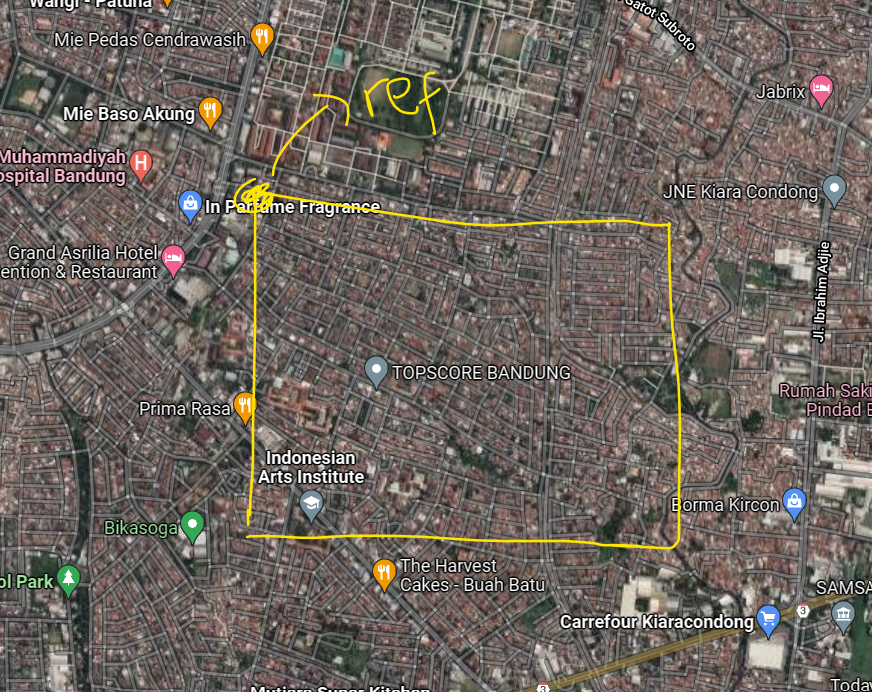

Each coordinate tuple has 4 elements, with the format: 
##### (south_boundary, north_boundary, west_boundary, east_boundary) in the corresponding latitude and longitude

#### Bandar Lampung
bla_1 = Bandar Lampung 1 (-5.442377267145909,-5.348555727020868, 105.21680768820622, 105.3232328002183) (5000) <br>

#### Bandung 

survey = Wilayah Riset Sharon (-6.8841756, -6.8500000, 107.583333, 107.620739) <br>
atlc = Atlantic City (-6.9124769724156225,-6.906905400138247, 107.59793960005668, 107.60385353168678) <br>
pkja_1 = Pemukiman Pasir Koja 1 (-6.926408767252975,-6.920380453838745, 107.59784891098272, 107.58654771231178) <br>
pkja_2 = Pemukiman Pasir Koja 2 (-6.932829671004056,-6.926103924147311, 107.58858728711887, 107.59615961041975) <br>
skas = Suka Asih (-6.944827442189124,-6.935697659966391, 107.58930832302306, 107.59522607461214) <br>
atnr = Astana Anyar (-6.937408091509106, -6.927103506094196, 107.60086606105602,107.61516600138631) <br>
blgd = Balong Gede (-6.9306750633193595,-6.922772112776385, 107.60744697277151, 107.61575316141095) <br>
lnkg = Lengkong (-6.9442514288190385, -6.933296579452376, 107.62705815049178, 107.6415713063336) <br>

#### Banjar
bjr = Kabupaten Banjar, Jabar (-7.56310450383076,-7.313907404214831, 108.46673058342367,  108.8601784621234) (1600) <br>

#### Bekasi
bksi_1 = Kota Bekasi 1 (-6.296502795127679, -6.221650075169667, 106.9588760637289, 107.00924171633727) (400 x 4) <br>
bksi_2 = Kota Bekasi 2 (-6.26476475618568, -6.208451763368825, 107.03302812178102, 107.12795685561579) (500 x 4) <br>

#### Belitung
bltg = Pulau Belitung (-3.2050990558587094, -2.538521606647078, 107.45775019819786, 108.20756702544287) (500) radius 9k <br>

#### Bogor
bgr_1 = Kota Bogor 1 (-6.612776141412416, -6.583381826462181, 106.74770286197179, 106.7689507720329) (800) <br>
bgr_2 = Kota Bogor 2 (-6.600515637027798, -6.581800323420126, 106.79789777825935, 106.81656595132779) (700) <br>
bgr_3 = Kota Bogor 3 (-6.5634797265679365, -6.526200015380743, 106.75787019341473, 106.81807577810962) (1800) <br>

#### Bulukumba
blkb = Bulukumba (-5.5622308632604005, -5.541163649496598, 120.18361096109305, 120.20135995162428) (150 * 4) <br>

#### Jakarta
jktb_1 = Jakarta Barat 1 (-6.185949639516899, -6.163528342609762, 106.76635309634018, 106.77786350637821) (150 * 4) <br>
jktb_2 = Jakarta Barat 2 ( -6.190162773499958, -6.1707924519240605, 106.73455882260623,106.7507379060853) (200 * 4) <br>
jktb_3 = Jakarta Barat 3 (-6.151589384463794, -6.141135565174551, 106.74420605738894, 106.7487979988538) (120 * 4) <br>
jkts_1 = Jakarta Selatan 1 (-6.485585894588078,-6.478827298621194, 106.69524731806379, 106.70108380441168) (50 * 4) <br>
jkts_2 = Jakarta Selatan 2 (-6.260329702342103, -6.245522593673656, 106.78303374834383, 106.7901664298344) (50 * 4) <br>
jktt_1 = Jakarta Timur 1 (-6.3365994231739835, -6.318983368132869, 106.85028917284673, 106.86114675406743) (50 * 4) <br>
jktu_1 = Jakarta Utara 1 (-6.120639800762421, -6.10374193313524, 106.75083505312112, 106.76542626899084) (200 * 4) <br>

#### Karo
kro_1 = Karo 1 (3.1480972410648644, 3.1728031022952345, 98.27492891223295, 98.29152639952585) (50 * 4) <br>
kro_2 = Karo 2 (3.1121068287794267, 3.114225412520982, 98.26999618152763, 98.27265025386336) (30 * 4) <br>

#### Manado
mdo_1 = Manado 1 (1.4406185637904283, 1.4621751056223513, 124.78653839672702, 124.8523386571415) (150 * 4) <br>
mdo_2 = Manado 2 (1.437131457101702, 1.4970455426967255, 124.83045809064187, 124.85947362716198) (250 * 4) <br>

#### Nias
nias = Nias (0.5453852273817089, 1.495540975169802, 97.03644719408675, 97.93732601949468) (400) 15k <br>

#### Makassar
mks = Makassar (-5.2800353814540255, -5.102350007794591, 119.3974185500285, 119.5252842429471) (300 * 4) <br>

#### Padang
pdg_1 = Kota Padang 1 (-0.689579367224907,-0.5544986240254298, 100.08042163837789, 100.2294631920878) (100 * 4) <br>

#### Palembang
plm_1 = Kota Palembang 1 (-2.98133923640822,-2.9193609133672394, 104.69136621760093,  104.82015652935391) (5000) <br>

#### Pancurbatu, Sumut
pcrb = Pancurbatu (3.4380485237211706, 3.5595480166252065, 98.54638145992196, 98.60944141923919) <br>

#### Pelabuhan Ratu
plrt = Pelabuhan Ratu (-7.379068949222516, -7.268739937695934, 106.36641305713059, 106.65480417240786) (800) <br>

#### Serang
srg_1 = Kota Serang 1 (-6.201741359776163,-6.087936568325985, 106.06194199250228, 106.20321274569508) (2000) <br>

#### Semarang
smrg_1 = Kota Semarang 1 (-7.004841692714051, -6.983714086197118, 110.44222770075346, 110.46205458803931) <br>
smrg_2 = Kota Semarang 2 (-6.97723600807904, -6.971951007903122, 110.38949734413818, 110.4006546663052) <br>
smrg_3 = Kota Semarang 3 (-7.000889567167174, -6.988278839550571, 110.37051658618354, 110.3843509891263) <br>
smrg_a = Kabupaten Semarang 1 (-7.050147818140127, -7.0276421537847895, 110.4560807204765,110.48162547612829) <br>

#### Sulawesi
sulteng_1 = Sulawesi Tengah 1 (-0.5901110007023506, 1.4257225826126763, 119.62443860310353, 122.62919907565312) (400) radius 60k <br>
sulteng_2 = Sulawesi Tengah 2 (-1.6280590918726474, -0.8756806667741177, 121.92943852669936, 123.57189443399794) (400) radius 50k <br>


#### Surabaya
srby_1 = Kota Surabaya 1 (-7.30769611418881,-7.271238050293822, 112.7489901468989, 112.78452684223367) <br>
srby_2 = Kota Surabaya 2 (-7.2982042367346915, -7.250781353861762, 112.6469651851327, 112.71013656649842) <br>

#### Tangerang
bsd_1 = BSD 1 (-6.308968785915957,-6.297069048541438, 106.66585952524154,  106.68484386639851) (900) <br>
bd = Benda (-6.333827198510408, -6.323675592407383, 106.7021574715794, 106.71940944008259) (400) <br>
pbr_1 = Pamulang Barat 1 (-6.343591739094512, -6.331670506517304, 106.72698379714443, 106.73659739487795) (700) <br>
pmp_1 = Permata Pamulang (-6.358047248070161, -6.350199333772839, 106.70935066171772, 106.718191222692) (500) <br>
sra_1 = Serua 1 (-6.362459551343062,-6.353479038452552, 106.74144408995635,  106.74648947792149) (400) <br>
flbn = Flamboyan (-6.3370314745669925, -6.331687199300647, 106.7312662732102, 106.73743858079074) (50 * 4) <br>
rjy_1 = Reni Jaya 1 (-6.364730492562783, -6.361190461630144, 106.72016912788334, 106.7312627434784) (75 * 4) <br>
pmrg = Pamulang Regency (-6.327236463059921, -6.319171455175802, 106.7124648312781, 106.71994963967795) (90 * 4) <br>
ndah = Perumahan Nusa Indah (-6.312570776224011, -6.30500623237934, 106.70073057910177, 106.71793377971618) (125 * 4) <br>
bdah = Perumahan Bintaro Indah (-6.291913104740638, -6.285569674555206, 106.69828207866665, 106.72226349887795) (125 * 4) <br>

#### Tasikmalaya
tsk = Kabupaten Tasikmalaya (-7.396696649562722,-7.29931273062956, 108.04580382994575,  108.29230956895658) (3000) <br>

#### Watampone
wtpn = Kabupaten Watampone (-4.559129518266895, -4.535857065699321, 120.31710371433411, 120.33478483474094) (100 * 4) <br>

In [ ]:
cisitu_coord = (-6.884278974324212, -6.875498096981807, 107.6082527220046, 107.616788161946)
DU_coord = (-6.897436096939215, -6.892689559418184, 107.61970131291098, 107.62732188490956)
sharon_coord = (-6.8841756, -6.8500000, 107.583333, 107.620739)
atlc = (-6.9124769724156225,-6.906905400138247, 107.59793960005668, 107.60385353168678)
pkja_1 = (-6.926408767252975,-6.920380453838745, 107.59784891098272, 107.58654771231178)
pkja_2 = (-6.932829671004056,-6.926103924147311, 107.58858728711887, 107.59615961041975)
skas = (-6.944827442189124,-6.935697659966391, 107.58930832302306, 107.59522607461214)
atnr = (-6.937408091509106, -6.927103506094196, 107.60086606105602,107.61516600138631)
blgd = (-6.9306750633193595,-6.922772112776385, 107.60744697277151, 107.61575316141095)
lnkg = (-6.9442514288190385, -6.933296579452376, 107.62705815049178, 107.6415713063336)
smrg_1 = (-7.004841692714051, -6.983714086197118, 110.44222770075346, 110.46205458803931)
smrg_2 = (-6.97723600807904, -6.971951007903122, 110.38949734413818, 110.4006546663052)
smrg_3 = (-7.000889567167174, -6.988278839550571, 110.37051658618354, 110.3843509891263)
smrg_a = (-7.050147818140127, -7.0276421537847895, 110.4560807204765,110.48162547612829)
srby_1 = (-7.30769611418881,-7.271238050293822, 112.7489901468989, 112.78452684223367)
srby_2 = (-7.2982042367346915, -7.250781353861762, 112.6469651851327, 112.71013656649842)
bgr_1 = (-6.612776141412416, -6.583381826462181, 106.74770286197179, 106.7689507720329)
bgr_2 = (-6.600515637027798, -6.581800323420126, 106.79789777825935, 106.81656595132779)
bgr_3 = (-6.5634797265679365, -6.526200015380743, 106.75787019341473, 106.81807577810962)
srg_1 = (-6.201741359776163,-6.087936568325985, 106.06194199250228, 106.20321274569508)

bla_1 = (-5.442377267145909,-5.348555727020868, 105.21680768820622, 105.3232328002183)
bjr = (-7.56310450383076,-7.313907404214831, 108.46673058342367,  108.8601784621234)
plm_1 = (-2.98133923640822,-2.9193609133672394, 104.69136621760093,  104.82015652935391)
plrt = (-7.379068949222516, -7.268739937695934, 106.36641305713059, 106.65480417240786)
tsk = (-7.396696649562722,-7.29931273062956, 108.04580382994575,  108.29230956895658)

bsd_1 = (-6.308968785915957,-6.297069048541438, 106.66585952524154,  106.68484386639851)  
bd = (-6.333827198510408, -6.323675592407383, 106.7021574715794, 106.71940944008259)  
pbr_1 = (-6.343591739094512, -6.331670506517304, 106.72698379714443, 106.73659739487795) 
pmp_1 = (-6.358047248070161, -6.350199333772839, 106.70935066171772, 106.718191222692) 
sra_1 = (-6.362459551343062,-6.353479038452552, 106.74144408995635,  106.74648947792149)

pdg_1 = (-0.689579367224907, -0.5544986240254298, 100.08042163837789, 100.2294631920878)

jktb_1 = (-6.185949639516899, -6.163528342609762, 106.76635309634018, 106.77786350637821)
jktb_2 = ( -6.190162773499958, -6.1707924519240605, 106.73455882260623,106.7507379060853)
jktb_3 = (-6.151589384463794, -6.141135565174551, 106.74420605738894, 106.7487979988538)
jkts_1 = (-6.485585894588078,-6.478827298621194, 106.69524731806379, 106.70108380441168)
jkts_2 = (-6.260329702342103, -6.245522593673656, 106.78303374834383, 106.7901664298344)
jktt_1 = (-6.3365994231739835, -6.318983368132869, 106.85028917284673, 106.86114675406743)
jktu_1 = (-6.120639800762421, -6.10374193313524, 106.75083505312112, 106.76542626899084)

pcrb = (3.4380485237211706, 3.5595480166252065, 98.54638145992196, 98.60944141923919)

kro_1 = (3.1480972410648644, 3.1728031022952345, 98.27492891223295, 98.29152639952585)
kro_2 = (3.1121068287794267, 3.114225412520982, 98.26999618152763, 98.27265025386336)

bksi_1 = (-6.296502795127679, -6.221650075169667, 106.9588760637289, 107.00924171633727)
bksi_2 = (-6.26476475618568, -6.208451763368825, 107.03302812178102, 107.12795685561579)

mdo_1 = (1.4406185637904283, 1.4621751056223513, 124.78653839672702, 124.8523386571415)
mdo_2 = (1.437131457101702, 1.4970455426967255, 124.83045809064187, 124.85947362716198)
mks = (-5.2800353814540255, -5.102350007794591, 119.3974185500285, 119.5252842429471)
wtpn = (-4.559129518266895, -4.535857065699321, 120.31710371433411, 120.33478483474094)
blkb = (-5.5622308632604005, -5.541163649496598, 120.18361096109305, 120.20135995162428)

flbn = (-6.3370314745669925, -6.331687199300647, 106.7312662732102, 106.73743858079074)
rjy_1 = (-6.364730492562783, -6.361190461630144, 106.72016912788334, 106.7312627434784)
pmrg = (-6.327236463059921, -6.319171455175802, 106.7124648312781, 106.71994963967795)
ndah = (-6.312570776224011, -6.30500623237934, 106.70073057910177, 106.71793377971618) 
bdah = (-6.291913104740638, -6.285569674555206, 106.69828207866665, 106.72226349887795)

bltg = (-3.2050990558587094, -2.538521606647078, 107.45775019819786, 108.20756702544287)
nias = (0.5453852273817089, 1.495540975169802, 97.03644719408675, 97.93732601949468)
sulteng_1 = (-0.5901110007023506, 1.4257225826126763, 119.62443860310353, 122.62919907565312)
sulteng_2 = (-1.6280590918726474, -0.8756806667741177, 121.92943852669936, 123.57189443399794)

## The code below is only for experimental purpose in some new regions

In [ ]:
lat_trial = -6.868645
lon_trial = 107.584584

trial_coord = str(lat_trial)+','+str(lon_trial)
trial_name = str(np.round(lat_trial,6)) + ' - ' + str(np.round(lon_trial,6)) + '.jpg'
trial_name = "kbnbbt18"

meta_params = {'key': API_KEY,
               'location': "Jalan Kebon Bibit no.3, Taman Sari"}
pic_params = {'key': API_KEY,
              'location': "Jalan Kebon Bibit no.3, Taman Sari",
              'fov' : '90',
              'radius' : 50,
              'heading' : 90,
             'size' : "256x256"}

meta_base = 'https://maps.googleapis.com/maps/api/streetview/metadata?'
base_url = 'https://maps.googleapis.com/maps/api/streetview?'

meta_response = requests.get(meta_base, params=meta_params)
response = requests.get(base_url,params = pic_params)

meta_response.json().get("status")
dirs = 'Generator Trial Results/'+'trial_'+trial_name

if(response.ok == True):
    with open(dirs, 'wb') as file:
        file.write(response.content)
    response.close()

plt.figure(figsize = (10, 10))
img = mpimg.imread(dirs)
imgplot = plt.imshow(img)
plt.show()

## Kode Aktual untuk melakukan Data Mining (melakukan query) pada GSV API

Fungsi **sv_mining**:
Melakukan koleksi data dengan parameter koordinat, dimana koordinat terdiri dari *tuple* yang terdiri dari 4 nilai, yaitu lat-lon untuk sisi kiri atas dan lat-lon untuk sisi kanan bawah. Parameter *loc_name* untuk membedakan nama file, serta *num_query* untuk menentukan jumlah gambar yang diambil pada area tinjauan

Heading dibuat random dengan nilai berikut [0, 90, 180, 270] karena keterbatasan teknis untuk mengetahui posisi bangunan di koordinat yang dituju

Ukuran gambar yang diambil adalah 256x256 untuk dimasukkan ke dalam sistem *Convolutional Neural Network*

In [ ]:
model = models.load_model('Deep Learning Models/ResNet-50_binary.h5')

In [ ]:
'''
Use the API key obtained from signing up to Google Cloud Platform (requires debit/credit card data) 
for payment if usage exceeds the monthly free quota (28500 free queries/month)
'''

API_KEY = 'enter your API_KEY here'

meta_base = 'https://maps.googleapis.com/maps/api/streetview/metadata?'
base_url = 'https://maps.googleapis.com/maps/api/streetview?'

In [ ]:
'''
sv_mining (street_view mining) function:
Parameter:
coord : Coordinates of the lat-lon boundary as the search boundary with the format (south, north, west, east)
loc_name : String to store data mining photos, with predefined area name code,
           to make it easier to find photos from a certain area
num_query : Number of searches the GSV API wants to execute
min_threshold : Minimum confidence of the sigmoid function of the AI model to distinguish buildings/non-buildings 
                so that photos can be saved.
                If min_threshold is too small, the 'junk' images are also taken (less sensitive).
                Taking too large a min_threshold will result in higher quality photos, but tends to be waste quota (over-sensitive)
ppc, fpc : Threshold for each photo search at certain coordinates, with various headings
radius : search radius of the nearest street photo from random coordinates
size: resolution of the images taken
'''
def sv_mining(coord, loc_name, num_query, min_threshold = 0.65, 
              ppc = 3, fpc = 3, radius = 50, size = "256x256"):
    not_found = 0
    for i in range(num_query):
        location_coord, file_name = generate_random_coord(coord)
        heading_list = ["0", "180", "90", "270", "45", "225", "135", "315"]
        random.shuffle(heading_list)
        dapat_gambar = 0
        fail = 0
        for cnt,j in enumerate(heading_list):
            heading = str(j)
            if(dapat_gambar > ppc):
                print('dapat, next!')
                continue
            if(fail > fpc):
                print('fail, next!')
                continue
            meta_response, response = GSV_query(meta_base, base_url,
                                                API_KEY, location_coord, heading, radius, size)
            if(meta_response.json().get("status") == 'OK'):
                dirs = 'Generator Results 3/'+ loc_name + file_name + '_' + j + '.jpg'
                if(response.ok == True):
                    index = i*4 + cnt + 1
                    if(index % 50 == 0):
                        print('Pencarian gambar ke - ' + str(index))
                    with open(dirs, 'wb') as file:
                        file.write(response.content)
                    response.close()
                    img_preprocessed = preprocess_image(dirs, target_size = (256,256))
                    prediction = np.squeeze(model.predict(img_preprocessed))
                    if prediction < min_threshold:
                        os.remove(dirs)
                        print("Gambar tidak mampu diidentifikasi pada koordinat "+ str(location_coord)
                             + " dan heading " + heading)
                        fail += 1
                    else:
                        print("BISA DIQUERY YEY")
                        dapat_gambar += 1
            else:
                not_found+= 1
    print("Total gambar tidak mampu di-query : "+ str(not_found) + " gambar")

With a set of boundary coordinates that have been found previously, street view imagery can be discovered using *data mining* in the area, with the target of image-taking experiments, image-finding radius, and several other technical parameters.

In [ ]:
sv_mining(nias, 'nias', num_query = 30, min_threshold = 0.7,
          ppc = 3, fpc = 3, radius = 100, size = "256x256")